In [1]:
import pandas as pd
import datetime
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    make_scorer,
    precision_recall_fscore_support,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import VarianceThreshold

import joblib

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set visual style
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')
data.head()

,ID,NEIGHBOURHOOD_NAME,LOCATION_TYPE,SPECIES_BOTANICAL,SPECIES_COMMON,GENUS,SPECIES,CULTIVAR,DIAMETER_BREAST_HEIGHT,CONDITION_PERCENT,PLANTED_DATE,OWNER,Bears Edible Fruit,Type of Edible Fruit,COUNT,LATITUDE,LONGITUDE,LOCATION,Point Location
0,NaN,EKOTA,Alley,Acer negundo,"Maple, Manitoba",Acer,negundo,NaN,16,65,1990/06/01,Parks,False,NaN,1,53.449926,-113.438612,"(53.449926073950685, -113.43861213854582)",POINT (-113.43861213854582 53.449926073950685)
1,NaN,KILLARNEY,Boulevard,Picea,Spruce,Picea,NaN,NaN,25,60,1992/07/06,Parks,False,NaN,1,53.590651,-113.479897,"(53.590650973168195, -113.47989663514004)",POINT (-113.47989663514004 53.590650973168195)
2,NaN,WESTMOUNT,Park,Pinus,Pine,Pinus,NaN,NaN,26,0,1990/01/01,Parks,False,NaN,1,53.554335,-113.544354,"(53.55433543089988, -113.54435356606548)",POINT (-113.54435356606548 53.55433543089988)
3,NaN,OTTEWELL,Alley,Ulmus pumila,"Elm, Siberian",Ulmus,pumila,NaN,30,65,1990/01/01,Parks,False,NaN,1,53.527287,-113.420573,"(53.52728665570487, -113.42057260617389)",POINT (-113.42057260617389 53.52728665570487)
4,570182.0,DOWNTOWN,Boulevard,Tilia,Linden,Tilia,NaN,NaN,27,65,1990/01/01,Parks,False,NaN,1,53.547699,-113.503689,"(53.54769938649941, -113.50368903245239)",POINT (-113.50368903245239 53.54769938649941)


# Data Modifications

In [3]:
def get_rare_categories(column, threshold):
    """Group rare categories in a categorical column into an 'Other' category."""
    counts = column.value_counts()
    rare_categories = [x for x in column if pd.notna(x) and counts[x] < threshold]
    return rare_categories


def classify_condition(row):
    """Classify tree condition based on thresholds of age and condition percentage."""
    age = row['TREE_AGE']
    condition = row['CONDITION_PERCENT']
    if condition == 0 and age < 50:
        return 'VERY POOR'
    elif condition <= 50 and age < 50:
        return 'POOR'
    elif condition <= 30 and age >= 50:
        return 'POOR'
    elif 51 <= condition <= 65 and age < 50:
        return 'MEDIOCRE'
    elif 31 <= condition <= 50 and age >= 50:
        return 'MEDIOCRE'
    elif 66 <= condition <= 79 and age < 50:
        return 'GOOD'
    elif 51 <= condition <= 70 and age >= 50:
        return 'GOOD'
    elif condition >= 80 and age < 50:
        return 'GREAT'
    elif condition >= 71 and age >= 50:
        return 'GREAT'
    return 'UNKNOWN'


# --- Data Preprocessing ---
# Calculate tree age
data['PLANTED_DATE'] = pd.to_datetime(data['PLANTED_DATE'], errors='coerce')
current_year = pd.Timestamp.now().year
data['TREE_AGE'] = current_year - data['PLANTED_DATE'].dt.year

# Handle missing values
data = data.dropna(subset=['CONDITION_PERCENT', 'DIAMETER_BREAST_HEIGHT'])  # Drop critical missing rows

# --- Train-Test Split ---
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# ---------- fixed to only use the median in train set not full data
# Fill missing TREE_AGE with median from train data
train_data['TREE_AGE'] = train_data['TREE_AGE'].fillna(train_data['TREE_AGE'].median())
test_data['TREE_AGE'] = test_data['TREE_AGE'].fillna(train_data['TREE_AGE'].median())


# Define condition classification
train_data['CONDITION_LABEL'] = train_data.apply(classify_condition, axis=1)
test_data['CONDITION_LABEL'] = test_data.apply(classify_condition, axis=1)

X_train = train_data.drop('CONDITION_LABEL', axis=1)
y_train = train_data['CONDITION_LABEL']
X_test = test_data.drop('CONDITION_LABEL', axis=1)
y_test = test_data['CONDITION_LABEL']

rare_neighbourhoods = get_rare_categories(X_train['NEIGHBOURHOOD_NAME'],5)
rare_species = get_rare_categories(X_train['SPECIES_BOTANICAL'],10)

# ---------- =fixed to only use data in train set not full data
# Reduce high-cardinality categories
X_train['NEIGHBOURHOOD_NAME'] =  X_train['NEIGHBOURHOOD_NAME'].replace(rare_neighbourhoods,'Other') # Group rare neighborhoods (less than 5)
X_train['SPECIES_BOTANICAL'] =  X_train['SPECIES_BOTANICAL'].replace(rare_species,'Other')    # Group rare neighborhoods (less than 10)



# EDA

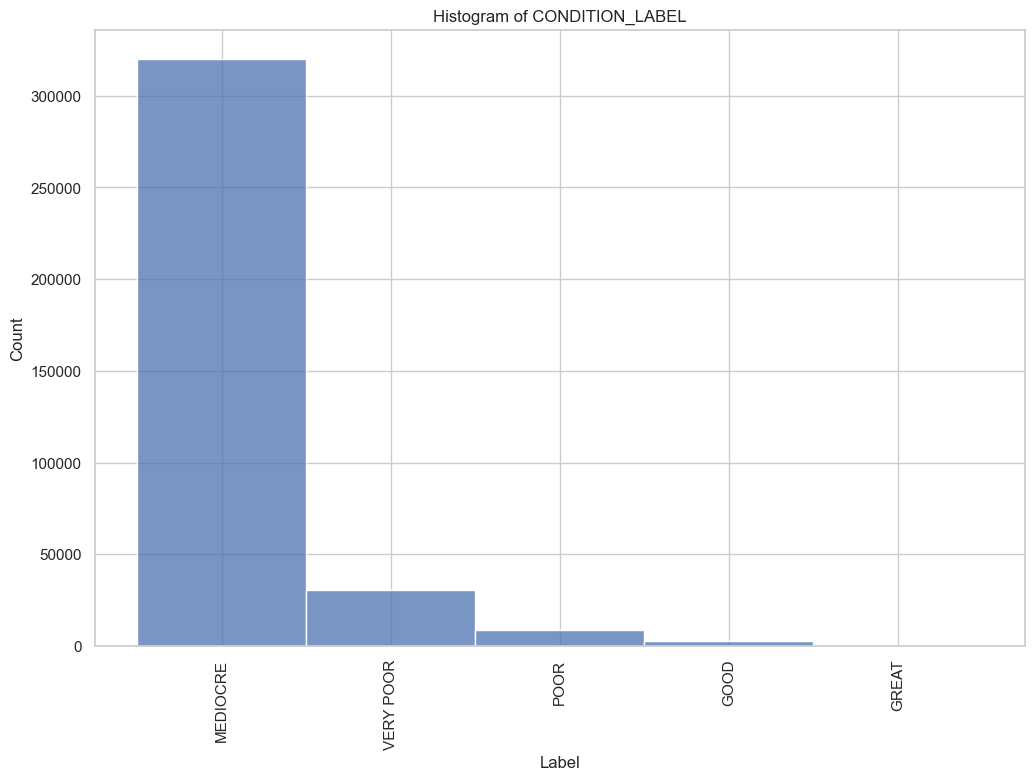

In [4]:
# Plot the distribution of CONDITION_LABEL
plt.figure(figsize=(12, 8))
sns.histplot(train_data, x= 'CONDITION_LABEL')
plt.xticks(rotation=90)
plt.title('Histogram of CONDITION_LABEL')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


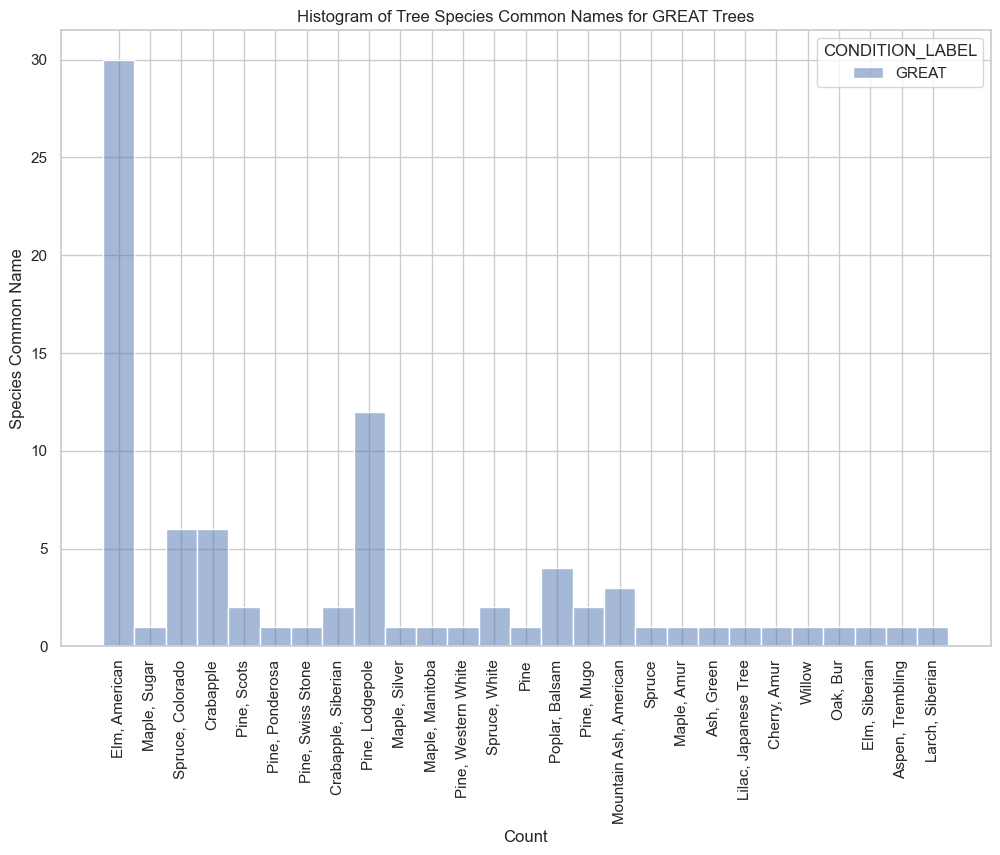

In [5]:
# Plot the distribution of SPECIES_COMMON for 'great' trees
plt.figure(figsize=(12, 8))
sns.histplot(train_data[train_data['CONDITION_LABEL'] == 'GREAT'], x= 'SPECIES_COMMON',hue='CONDITION_LABEL')
plt.xticks(rotation=90)
plt.title('Histogram of Tree Species Common Names for GREAT Trees')
plt.xlabel('Count')
plt.ylabel('Species Common Name')
plt.show()


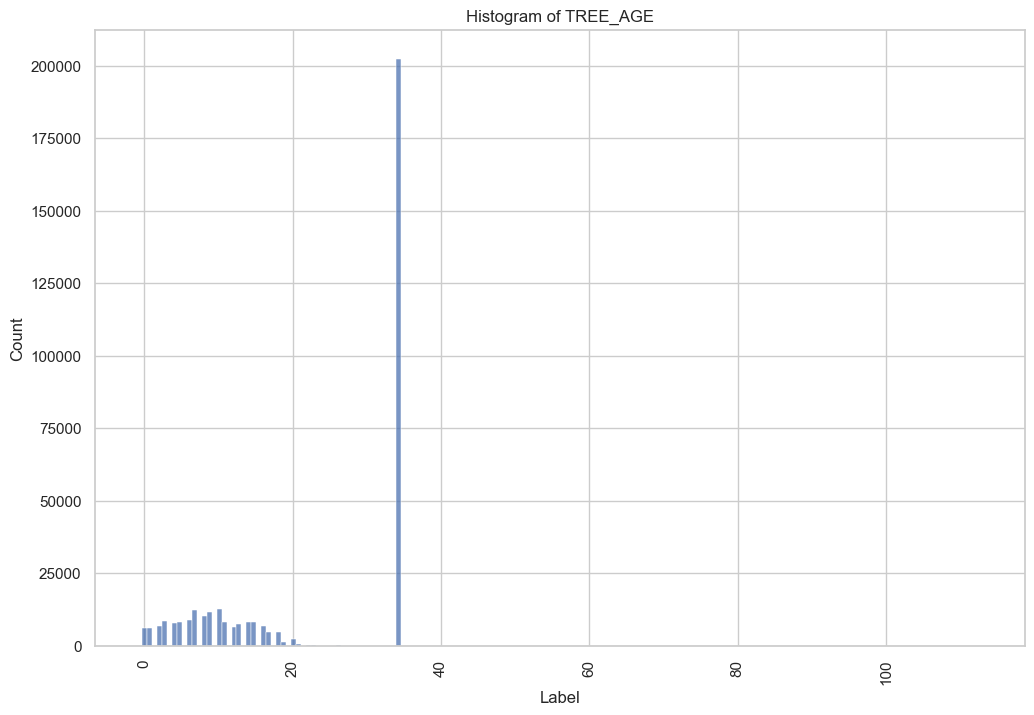

In [6]:
# Plot the distribution of TREE_AGE
plt.figure(figsize=(12, 8))
sns.histplot(train_data, x= 'TREE_AGE')
plt.xticks(rotation=90)
plt.title('Histogram of TREE_AGE')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


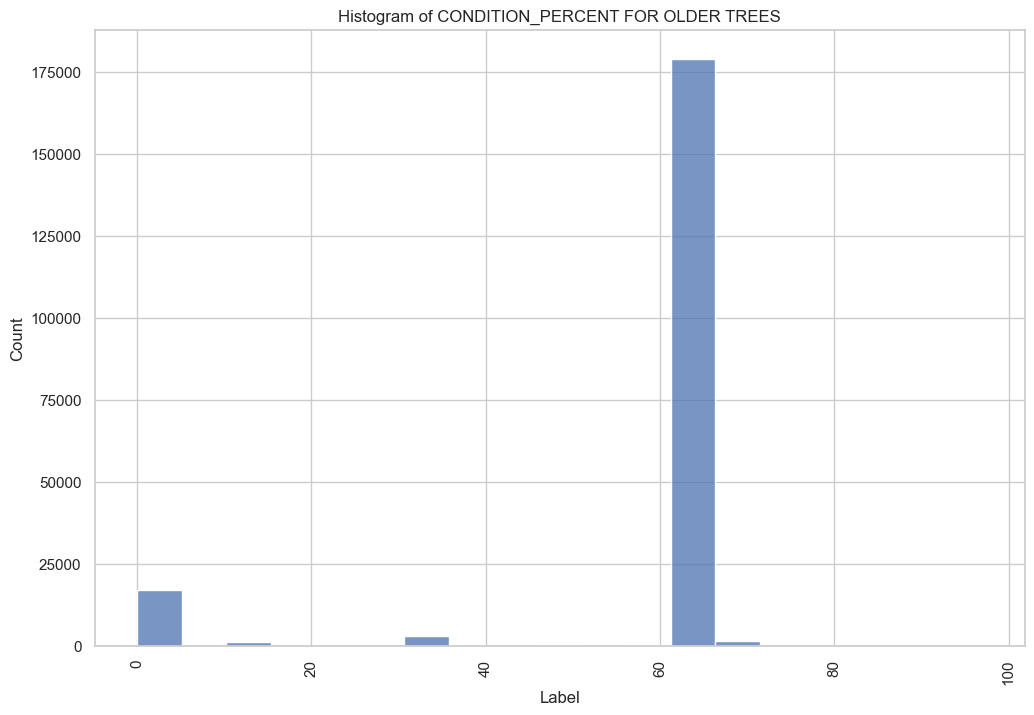

In [7]:
# distribution of condition percent for trees >= 30

plt.figure(figsize=(12, 8))
sns.histplot(train_data[train_data['TREE_AGE'] >= 30], x= 'CONDITION_PERCENT')
plt.xticks(rotation=90)
plt.title('Histogram of CONDITION_PERCENT FOR OLDER TREES')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

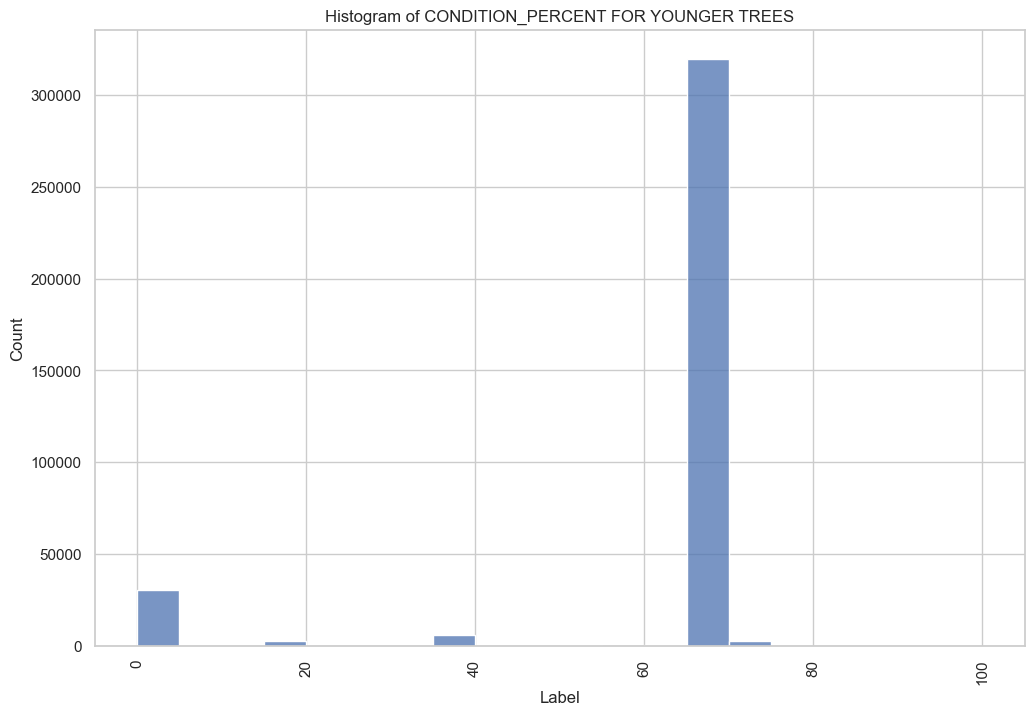

In [8]:
# distribution of condition percent for trees < 30

plt.figure(figsize=(12, 8))
sns.histplot(train_data[train_data['TREE_AGE'] < 35], x= 'CONDITION_PERCENT')
plt.xticks(rotation=90)
plt.title('Histogram of CONDITION_PERCENT FOR YOUNGER TREES')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [9]:
#------------ how did they get useful columns?
# Filter for useful columns (include SPECIES_COMMON)
useful_cols = ['NEIGHBOURHOOD_NAME', 'DIAMETER_BREAST_HEIGHT', 'TREE_AGE', 
               'SPECIES_BOTANICAL', 'SPECIES_COMMON']

#feature selection
X_train = X_train[useful_cols]
X_test = X_test[useful_cols]


# Encode categorical features
categorical_features = ['NEIGHBOURHOOD_NAME', 'SPECIES_BOTANICAL']
numerical_features = ['DIAMETER_BREAST_HEIGHT', 'TREE_AGE']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# --- Feature Selection ---
# Optional: Filter low-variance features (if any)
def low_variance_filter(X, threshold=0.01):
    sel = VarianceThreshold(threshold=threshold)
    return sel.fit_transform(X)


In [10]:

# --- Model Training ---
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning with reduced iterations and folds
param_grid = {
    'classifier__n_estimators': [10, 50],  # Fewer estimators for faster tuning
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5]
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=8,  # Limited iterations
    cv=2,  # Reduced folds for faster tuning
    scoring='accuracy',
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# Fit with subsampling to reduce dataset size during tuning
sample_data = train_data.sample(frac=0.2, random_state=42)  # Use 20% of the dataset
X_sample = sample_data.drop('CONDITION_LABEL', axis=1)
y_sample = sample_data['CONDITION_LABEL']
random_search.fit(X_sample, y_sample)

# --- Model Evaluation ---
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model on the training set
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = 1 - train_accuracy
print("Training Accuracy:", train_accuracy)
print("Training Error:", train_error)

# Evaluate the model on the testing set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
print("Testing Accuracy:", test_accuracy)
print("Testing Error:", test_error)

# Evaluate the model on the full dataset
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Model Accuracy:", accuracy_score(y_test, y_pred))


Training Accuracy: 0.9029226950884445
Training Error: 0.09707730491155553
Testing Accuracy: 0.8944042322420701
Testing Error: 0.10559576775792989
Classification Report:
              precision    recall  f1-score   support

        GOOD       0.58      0.30      0.39       603
       GREAT       0.38      0.21      0.27        24
    MEDIOCRE       0.91      0.98      0.94     80163
        POOR       0.33      0.07      0.12      2111
   VERY POOR       0.56      0.26      0.35      7453

    accuracy                           0.89     90354
   macro avg       0.55      0.36      0.42     90354
weighted avg       0.87      0.89      0.87     90354

Model Accuracy: 0.8944042322420701


In [11]:
#### the target has changed to condition label in this new model, is that intentional? I thought y was the species.
#### we can point out in the presentation the amazing performance on 'mediocre' trees vs the rest. We have more data points 'support' to predict in that category.

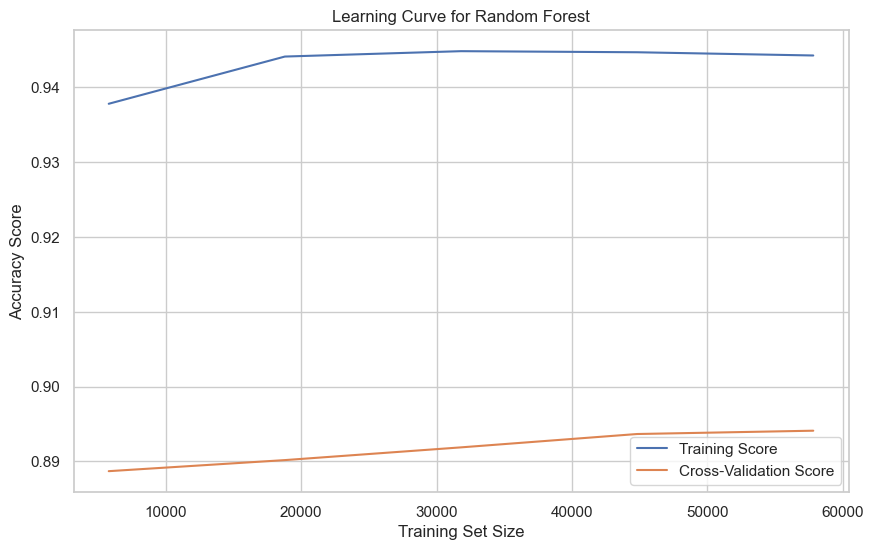

In [12]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_sample, y_sample, scoring='accuracy', train_sizes=[np.linspace(0.1, 1.0, 5)]
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
plt.title('Learning Curve for Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()